In [3]:
import sys
assert sys.version_info >= (3, 5)

import tensorflow as tf
assert tf.__version__ >= "2.0"
import sklearn
import keras

%load_ext tensorboard

#import other common packages
import os
import numpy as np

#specify fig printing
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

#specify location for saving figures
project_root_dir = "."
project_id = "sun397"
images_path = os.path.join(project_root_dir, "images", project_id)
os.makedirs(images_path, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(images_path, fig_id + "." + fig_extension)
  print("saving figure", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

#set random seed
np.random.seed(42)
tf.random.set_seed(42)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
from tensorflow.keras.datasets import cifar100
(X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 2779s 16us/step


In [5]:
X_train, X_val = X_train_full[5000:], X_train_full[:5000]
y_train, y_val = y_train_full[5000:], y_train_full[:5000]

train_set_size = X_train.shape[0]
valid_set_size = X_val.shape[0]

#validate the shape of the datasets
print(f'X_train shape : {X_train.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'X_val shape : {X_val.shape}')
print(f'y_val shape : {y_val.shape}')
print(f'train_set_size : {train_set_size}')
print(f'valid_set_size : {valid_set_size}')

X_train shape : (45000, 32, 32, 3)
y_train shape : (45000, 1)
X_val shape : (5000, 32, 32, 3)
y_val shape : (5000, 1)
train_set_size : 45000
valid_set_size : 5000


In [6]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [7]:
#import necessary modules
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

def create_example(image, label): #saves dataset to a set of TFRecord files
  image_data = tf.io.serialize_tensor(image)
  return Example(
      features=Features(
          feature={
          "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
          "label": Feature(int64_list=Int64List(value=label))
      }
      )
  )

In [8]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
  paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards) for index in range(n_shards)]
  with ExitStack() as stack:
    writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
    for index, (image, label) in dataset.enumerate():
      shard = index % n_shards
      example = create_example(image, label)
      writers[shard].write(example.SerializeToString())
  return paths

In [9]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", val_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

In [10]:
def preprocess(tfrecord):
  feature_descriptions = {
      "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
      "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
  }
  example = tf.io.parse_single_example(tfrecord, feature_descriptions)
  image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
  image = tf.reshape(image, shape=[32, 32, 3])
  image = tf.image.resize(image, [299, 299])
  image = tf.keras.applications.xception.preprocess_input(image)
  return image, example["label"]

def cifar_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, n_parse_threads=5, batch_size=32, cache=True):
  dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
  if cache:
    dataset = dataset.cache()
  if shuffle_buffer_size:
    dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
  dataset = dataset.batch(batch_size)
  return dataset.prefetch(1)

In [11]:
train_set = cifar_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = cifar_dataset(valid_filepaths)
test_set = cifar_dataset(test_filepaths)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

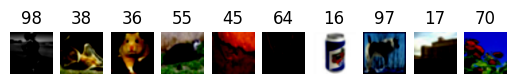

In [12]:
#visualize a sample of the images
for X, y in train_set.take(1):
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X[i], cmap="binary")
    plt.axis("off")
    plt.title(str(y[i].numpy()))

In [13]:
base_model = keras.applications.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(100, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 28s 0us/step


In [14]:
for index, layer in enumerate(base_model.layers):
  print (index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [15]:
#set the model layers to trainable.false
for layer in base_model.layers:
  layer.trainable=False

In [ ]:
#compile the model
batch_size = 32
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
history = model.fit(train_set, validation_data = valid_set, epochs=5)

Epoch 1/5
     22/Unknown - 979s 44s/step - loss: 4.2808 - accuracy: 0.1179